In [7]:
from dotenv import load_dotenv
load_dotenv()
import os

from langchain_openai import ChatOpenAI

os.environ["OPENAI_API_KEY"] = os.getenv("OPENAI_API_KEY")

llm = ChatOpenAI(model="gpt-3.5-turbo")
result = llm.invoke("Hello GPT")
result.content

'Hello! How can I assist you today?'

In [8]:
# custom tools

def multiply(a: int, b: int) -> int:
    """
    Multiply a and b
    Args:
    a: first int
    b: second int
    """
    return a*b

def divide(a: int, b: int) -> int:
    """
    Divide a by b
    Args: 
    a: first int
    b: second int
    """
    return a/b

In [5]:
tools = [multiply, divide]
tools

[<function __main__.multiply(a: int, b: int) -> int>,
 <function __main__.divide(a: int, b: int) -> int>]

In [9]:
# integrate tools with llm
llm_with_tools = llm.bind_tools(tools)
llm_with_tools

RunnableBinding(bound=ChatOpenAI(client=<openai.resources.chat.completions.completions.Completions object at 0x000002401D6EE030>, async_client=<openai.resources.chat.completions.completions.AsyncCompletions object at 0x000002401D6845C0>, root_client=<openai.OpenAI object at 0x000002401B883CB0>, root_async_client=<openai.AsyncOpenAI object at 0x000002401D268890>, model_kwargs={}, openai_api_key=SecretStr('**********')), kwargs={'tools': [{'type': 'function', 'function': {'name': 'multiply', 'description': 'Multiply a and b\nArgs:\na: first int\nb: second int', 'parameters': {'properties': {'a': {'type': 'integer'}, 'b': {'type': 'integer'}}, 'required': ['a', 'b'], 'type': 'object'}}}, {'type': 'function', 'function': {'name': 'divide', 'description': 'Divide a by b\nArgs: \na: first int\nb: second int', 'parameters': {'properties': {'a': {'type': 'integer'}, 'b': {'type': 'integer'}}, 'required': ['a', 'b'], 'type': 'object'}}}]}, config={}, config_factories=[])

In [2]:
## workflow with langgraph
from IPython.display import Image, display
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import MessagesState
from langgraph.graph import START, END, StateGraph
from langgraph.prebuilt import tools_condition, ToolNode
from langchain_core.messages import AIMessage, HumanMessage, SystemMessage


In [7]:
## system message
sys_msg = SystemMessage(content="You are a helpful assistant tasked with performing arithmatic on a set of inputs")



In [8]:
#Graph 
builder = StateGraph(MessagesState)


In [9]:
## node
def assistant(state: MessagesState):
    return {"messages": [llm_with_tools.invoke([sys_msg] + state["messages"])]}


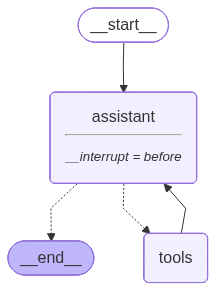

In [10]:
builder = StateGraph(MessagesState)

# define nodes
builder.add_node("assistant", assistant)
builder.add_node("tools", ToolNode(tools))

#define the Edges

builder.add_edge(START, "assistant")
builder.add_conditional_edges("assistant", tools_condition)
builder.add_edge("tools", "assistant")

memory = MemorySaver()

graph = builder.compile(interrupt_before=["assistant"],checkpointer=memory)

display(Image(graph.get_graph().draw_mermaid_png()))

In [11]:
thread = {"configurable":{"thread_id": "12"}}

initial_input = {"messages": HumanMessage(content="Multiply 2 and 3")}

In [12]:
for event in graph.stream(initial_input, thread, stream_mode="values"):
    event['messages'][-1].pretty_print()

================================ Human Message =================================

Multiply 2 and 3


In [13]:
# the above flow of execution has got interrupted

In [16]:
state = graph.get_state(thread)
state.next



('assistant',)

In [17]:
state_1 = graph.get_state_history(thread)
state_1

<generator object Pregel.get_state_history at 0x0000027428583A00>

In [18]:
## continue the execution
for event in graph.stream(None, thread, stream_mode="values"):
    event['messages'][-1].pretty_print()

================================ Human Message =================================

Multiply 2 and 3
================================== Ai Message ==================================
Tool Calls:
  multiply (call_kvmXVk02I3M9NXyhr7bOsxJ7)
 Call ID: call_kvmXVk02I3M9NXyhr7bOsxJ7
  Args:
    a: 2
    b: 3
================================= Tool Message =================================
Name: multiply

6


In [21]:
state_2 = graph.get_state(thread)
state_2.next

('assistant',)

In [22]:
## continue the execution
for event in graph.stream(None, thread, stream_mode="values"):
    event['messages'][-1].pretty_print()

================================= Tool Message =================================
Name: multiply

6
================================== Ai Message ==================================

The result of multiplying 2 and 3 is 6.


In [23]:
state_3 = graph.get_state(thread)
state_3.next

()

 Edit Human Feedback


In [24]:
initial_input={"messages": HumanMessage(content="Multiply 2 and 3")}

thread = {"configurable": {"thread_id": "4"}}
for event in graph.stream(initial_input, thread, stream_mode="values"):
    event['messages'][-1].pretty_print()

================================ Human Message =================================

Multiply 2 and 3


In [25]:
graph.get_state(thread).next

('assistant',)

In [26]:
graph.update_state(thread, {"messages": [HumanMessage(content="Please multiply 4 and 4")]})

{'configurable': {'thread_id': '4',
  'checkpoint_ns': '',
  'checkpoint_id': '1f09364a-e15c-685c-8001-37b58318eba4'}}

In [27]:
new_state = graph.get_state(thread).values

for m in new_state['messages']:
    m.pretty_print()

================================ Human Message =================================

Multiply 2 and 3
================================ Human Message =================================

Please multiply 4 and 4


In [28]:
for event in graph.stream(None, thread, stream_mode="values"):
    event['messages'][-1].pretty_print()

================================ Human Message =================================

Please multiply 4 and 4
================================== Ai Message ==================================
Tool Calls:
  multiply (call_TRY25gUcNHltTWJbb9ZLqVdu)
 Call ID: call_TRY25gUcNHltTWJbb9ZLqVdu
  Args:
    a: 4
    b: 4
================================= Tool Message =================================
Name: multiply

16


In [29]:
for event in graph.stream(None, thread, stream_mode="values"):
    event['messages'][-1].pretty_print()

================================= Tool Message =================================
Name: multiply

16
================================== Ai Message ==================================

The result of multiplying 4 and 4 is 16.


### wait for human input in the workflow

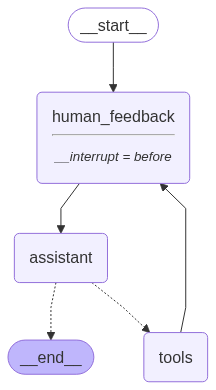

================================ Human Message =================================

Multiply 2 and 3


{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1f093682-33a8-6b5b-8001-2ecc2cc0e910'}}

In [10]:
sys_msg = SystemMessage(content="You are a helpful assistant tasked with performing arithmatic on a set of inputs")

### human feedback node

def human_feedback(state: MessagesState):
    pass

##assistant node
def assistant(state:MessagesState):
    return {"messages": [llm_with_tools.invoke([sys_msg] + state["messages"])]}

#graph 
builder = StateGraph(MessagesState)

# define nodes
builder.add_node("assistant", assistant)
builder.add_node("tools",ToolNode(tools))
builder.add_node("human_feedback", human_feedback)

## define edges
builder.add_edge(START, "human_feedback")
builder.add_edge("human_feedback", "assistant")
builder.add_conditional_edges("assistant", tools_condition)
builder.add_edge("tools", "human_feedback")

memory = MemorySaver()

graph = builder.compile(interrupt_before=["human_feedback"],checkpointer=memory)

display(Image(graph.get_graph().draw_mermaid_png()))

thread = {"configurable": {"thread_id": "1"}}

initial_input = {"messages": HumanMessage(content="Multiply 2 and 3")}

for event in graph.stream(initial_input, thread, stream_mode="values"):
    event['messages'][-1].pretty_print()

##get user input
user_input = input("Tell me how you want to update the state")
graph.update_state(thread, {"messages": user_input}, as_node="human_feedback")

for event in graph.stream(None, thread, stream_mode="values"):
    event['messages'][-1].pretty_print()

In [11]:
for event in graph.stream(None, thread, stream_mode="values"):
    event['messages'][-1].pretty_print()

================================ Human Message =================================


================================== Ai Message ==================================
Tool Calls:
  multiply (call_kRMlss0fFJnmDkKTS3ZMSm3h)
 Call ID: call_kRMlss0fFJnmDkKTS3ZMSm3h
  Args:
    a: 2
    b: 3
================================= Tool Message =================================
Name: multiply

6
